In [1]:
import io
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
from keras.utils import pad_sequences
from matplotlib import pyplot as plt

In [2]:
tokenizer = text.Tokenizer()

In [3]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

In [4]:
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}

In [5]:
corpus = [line.split(' ') for line in corpus]

In [6]:
wids = [[word2id[w] for w in sentence] for sentence in corpus]
vocab_size = len(word2id)

In [7]:
embed_size = 128
window_size = 2
context_length = window_size*2

In [8]:
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 31
Vocabulary Sample: [('9', 1), ('3', 2), ('o', 3), ('6', 4), ('a', 5), ('1', 6), ('g', 7), ('i', 8), ('4', 9), ('8', 10)]


In [9]:
def generate_context_word_pairs(corpus, window_size):
    pairs = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = context_words
            y = label_word
            pairs.append((x, y))
    return pairs

pairs = generate_context_word_pairs(wids, 2)

In [10]:
for pair in pairs[:5]:
  print(pair[0], pair[1])

[[16, 9]] [15]
[[15, 9, 10]] [16]
[[15, 16, 10, 4]] [9]
[[16, 9, 4, 16]] [10]
[[9, 10, 16, 2]] [4]


In [11]:
xs = []
ys = []
for pair in pairs:
  xs.append(pad_sequences(pair[0], maxlen=context_length))
  ys.append(tf.one_hot(pair[1], vocab_size))

for idx, x in enumerate(xs[:3]):
  print(x, ys[idx])


[[ 0  0 16  9]] tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)
[[ 0 15  9 10]] tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)
[[15 16 10  4]] tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)


2022-06-24 18:20:25.105081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
BATCH_SIZE = 4
BUFFER_SIZE = 1000
dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(1, 4), dtype=tf.int32, name=None), TensorSpec(shape=(1, 31), dtype=tf.float32, name=None))>


In [13]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.embedding = keras.layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=window_size*2,
                                      name="w2v_embedding")
    self.mean = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embedding_dim,))
    self.dense = keras.layers.Dense(vocab_size, activation='softmax')

  def call(self, context):
    word_emb = self.embedding(context)
    word_emb = self.mean(word_emb)
    pred = self.dense(word_emb)
    return pred

In [14]:
word2vec = Word2Vec(vocab_size, embed_size)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [15]:
word2vec.fit(dataset, epochs=100)

Epoch 1/100


/Users/ming8525/miniforge3/envs/c3-nlp/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


193/193 [==============================] - 1s 922us/step - loss: 3.4169 - accuracy: 0.0725
Epoch 2/100
193/193 [==============================] - 0s 779us/step - loss: 3.2554 - accuracy: 0.1917
Epoch 3/100
193/193 [==============================] - 0s 933us/step - loss: 3.0242 - accuracy: 0.2383
Epoch 4/100
193/193 [==============================] - 0s 774us/step - loss: 2.7792 - accuracy: 0.2694
Epoch 5/100
193/193 [==============================] - 0s 690us/step - loss: 2.5922 - accuracy: 0.2850
Epoch 6/100
193/193 [==============================] - 0s 816us/step - loss: 2.4474 - accuracy: 0.3057
Epoch 7/100
193/193 [==============================] - 0s 661us/step - loss: 2.3253 - accuracy: 0.2902
Epoch 8/100
193/193 [==============================] - 0s 891us/step - loss: 2.2193 - accuracy: 0.3057
Epoch 9/100
193/193 [==============================] - 0s 710us/step - loss: 2.1261 - accuracy: 0.3161
Epoch 10/100
193/193 [==============================] - 0s 1ms/step - loss: 2.0436 - 

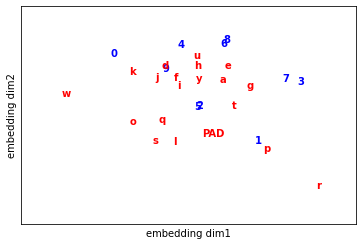

In [16]:
def show_w2v_word_embedding(model, path):
    word_emb = model.get_layer('w2v_embedding').get_weights()[0]
    # word_emb = model.get_weights()[0]
    word_emb = word_emb[1:]
    for i in range(vocab_size -1):
        c = "blue"
        try:
            int(id2word[i])
        except ValueError:
            c = "red"
        plt.text(word_emb[i, 0], word_emb[i, 1], s=id2word[i], color=c, weight="bold")
    plt.xlim(word_emb[:, 0].min() - .5, word_emb[:, 0].max() + .5)
    plt.ylim(word_emb[:, 1].min() - .5, word_emb[:, 1].max() + .5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
    plt.savefig(path, dpi=300, format="png")
    plt.show()

show_w2v_word_embedding(word2vec, './cbow.png')

In [17]:
# weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index in tokenizer.index_word:
#   if index == 0:
#     continue  # skip 0, it's padding.
#   word = tokenizer.index_word[index]
#   vec = weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()